<a href="https://colab.research.google.com/github/LeoTU911/SCC413/blob/main/VAE_1.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!nvidia-smi

Wed Feb 15 00:15:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    46W / 400W |   3094MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [18]:
!git clone https://github.com/LeoTU911/SCC413

fatal: destination path 'SCC413' already exists and is not an empty directory.


In [ ]:
#!ls -R

In [19]:
import os
import tensorflow as tf
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import backend as K
from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from PIL import Image

In [20]:
datadir = '/content/SCC413/CUHK_training_cropped_photos'
datadir = pathlib.Path(datadir)

rawData = tf.data.Dataset.list_files(str(datadir/'*'))

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

def img2data(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels = 3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

trainImage = rawData.map(img2data, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# test
for i in trainImage.take(5):
  print(i.numpy())

[[[0.45098042 0.8078432  0.9215687 ]
  [0.45098042 0.8078432  0.9215687 ]
  [0.45385158 0.81071436 0.92443985]
  ...
  [0.48258057 0.82375705 0.9296394 ]
  [0.48258057 0.82375705 0.9296394 ]
  [0.48258057 0.82375705 0.9296394 ]]

 [[0.45098042 0.8078432  0.9215687 ]
  [0.45155346 0.80841625 0.92214173]
  [0.45453435 0.81139714 0.9251226 ]
  ...
  [0.48627454 0.82745105 0.9333334 ]
  [0.48627454 0.82745105 0.9333334 ]
  [0.48627454 0.82745105 0.9333334 ]]

 [[0.45098042 0.8078432  0.9215687 ]
  [0.45427173 0.8111345  0.92486   ]
  [0.45777315 0.81463593 0.9283614 ]
  ...
  [0.48627454 0.82745105 0.9333334 ]
  [0.48627454 0.82745105 0.9333334 ]
  [0.48627454 0.82745105 0.9333334 ]]

 ...

 [[0.42858896 0.78545177 0.89917725]
  [0.42858896 0.78545177 0.89917725]
  [0.42858896 0.78545177 0.89917725]
  ...
  [0.31388912 0.32894516 0.30451566]
  [0.3447503  0.35980633 0.3369675 ]
  [0.32839632 0.34345236 0.3182773 ]]

 [[0.427451   0.7843138  0.8980393 ]
  [0.427451   0.7843138  0.8980393 ]


In [14]:
print(datadir)
type(datadir)

/content/SCC413/CUHK_training_cropped_photos


pathlib.PosixPath

In [22]:
def prepare_Training(data, cache = True, shuffle_buffer_size = 1000):
  if cache:
    if isinstance(cache, str):
      data = data.cache(cache)
    else:
      data = data.cache()
  
  data = data.shuffle(buffer_size = shuffle_buffer_size)
  data = data.repeat()
  data = data.batch(BATCH_SIZE)

  data = data.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

  return data

def show_batch(img_batch):
  plt.figure(figsize=(10,10))
  for i in range(25):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(img_batch[i])
    plt.axis('off')

trainingData = prepare_Training(trainImage)
image_batch = next(iter(trainingData))

show_batch(image_batch.numpy())

FailedPreconditionError: ignored

In [23]:
#image to grayscale image
filePath = '/content/SCC413/CUHK_training_cropped_photos'

images = []

for fileName in os.listdir(filePath):
  if fileName.endswith('.jpg'):
    img_tmp = Image.open(os.path.join(filePath, fileName)).convert('L')
    img_tmp = img_tmp.resize((128, 128))
    img_array = np.array(img_tmp)
    images.append(img_array)

x_train = np.array(images).reshape((-1, 128, 128, 1)).astype('float32') / 255.

In [24]:
print(x_train.shape)

(88, 128, 128, 1)


In [25]:
# 定义VAE模型
input_shape = (128, 128, 1)
batch_size = 1
latent_dim = 32
epochs = 100

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# 编码器
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
x = Conv2D(32, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)
x = Flatten()(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# 解码器
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(latent_inputs)
x = Reshape(shape_before_flattening[1:])(x)
x = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = Conv2D(1, 3, padding='same', activation='sigmoid')(x)

decoder = Model(latent_inputs, x, name='decoder')
decoder.summary()

# VAE模型
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

# 损失函数
reconstruction_loss = K.mean(K.binary_crossentropy(inputs, outputs))
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 128, 128, 32  320         ['encoder_input[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_6 (Conv2D)              (None, 64, 64, 64)   18496       ['conv2d_5[0][0]']               
                                                                                            

Epoch 1/100
88/88 [==============================] - 4s 7ms/step - loss: 1.0146
Epoch 2/100
88/88 [==============================] - 1s 7ms/step - loss: 0.6259
Epoch 3/100
88/88 [==============================] - 1s 7ms/step - loss: 0.6098
Epoch 4/100
88/88 [==============================] - 1s 7ms/step - loss: 0.6072
Epoch 5/100
88/88 [==============================] - 1s 7ms/step - loss: 0.6080
Epoch 6/100
88/88 [==============================] - 1s 7ms/step - loss: 0.6059
Epoch 7/100
88/88 [==============================] - 1s 7ms/step - loss: 0.6056
Epoch 8/100
88/88 [==============================] - 1s 7ms/step - loss: 0.6038
Epoch 9/100
88/88 [==============================] - 1s 7ms/step - loss: 0.6038
Epoch 10/100
88/88 [==============================] - 1s 7ms/step - loss: 0.6036
Epoch 11/100
88/88 [==============================] - 1s 7ms/step - loss: 0.6034
Epoch 12/100
88/88 [==============================] - 1s 7ms/step - loss: 0.6029
Epoch 13/100
88/88 [=================

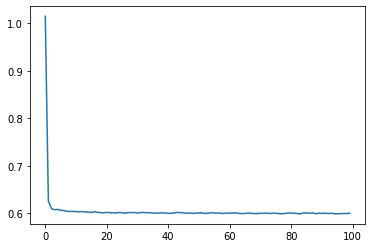

In [26]:
# 训练模型
vae.fit(x_train, epochs=epochs, batch_size=batch_size)

# plot
plt.plot(vae.history.history["loss"])
#plt.plot(vae.history.history["val_loss"])

3/3 [==============================] - 0s 3ms/step


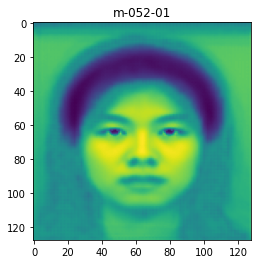

3/3 [==============================] - 0s 3ms/step


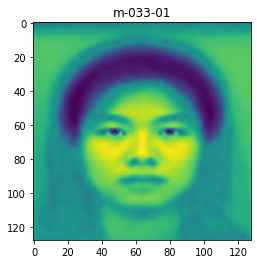

3/3 [==============================] - 0s 3ms/step


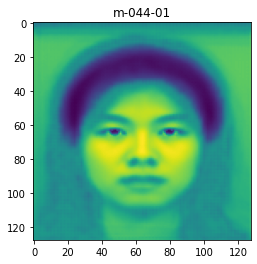

3/3 [==============================] - 0s 3ms/step


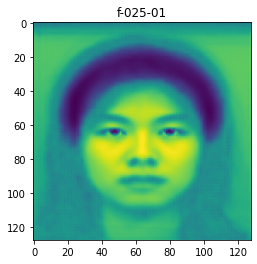

3/3 [==============================] - 0s 3ms/step


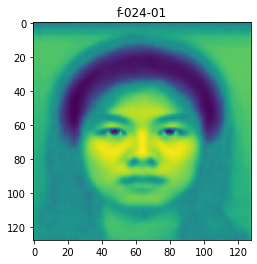

3/3 [==============================] - 0s 3ms/step


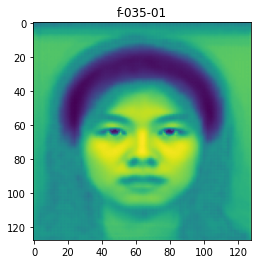

3/3 [==============================] - 0s 3ms/step


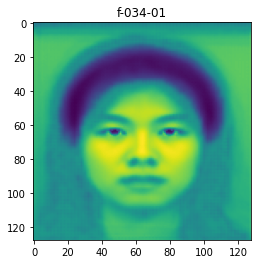

3/3 [==============================] - 0s 3ms/step


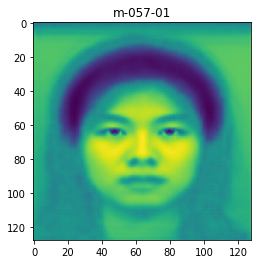

3/3 [==============================] - 0s 3ms/step


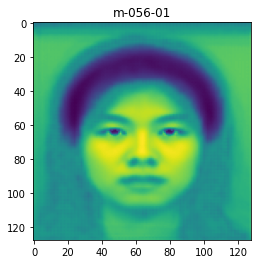

3/3 [==============================] - 0s 3ms/step


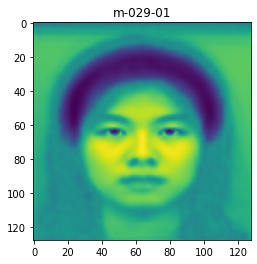

3/3 [==============================] - 0s 3ms/step


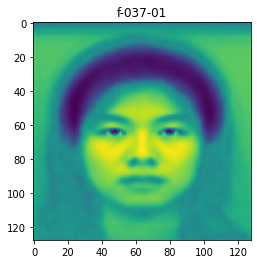

3/3 [==============================] - 0s 3ms/step


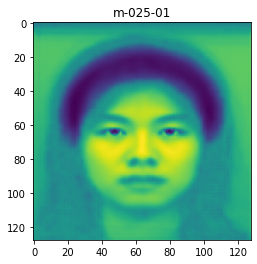

3/3 [==============================] - 0s 3ms/step


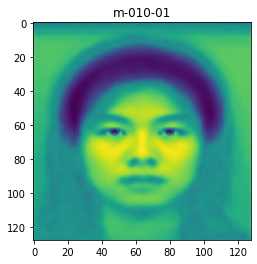

3/3 [==============================] - 0s 3ms/step


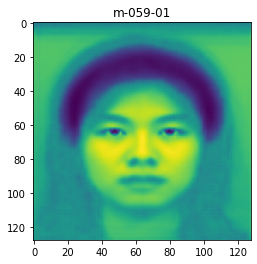

3/3 [==============================] - 0s 3ms/step


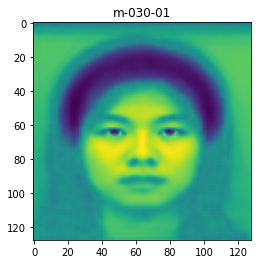

3/3 [==============================] - 0s 3ms/step


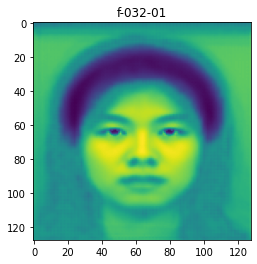

3/3 [==============================] - 0s 3ms/step


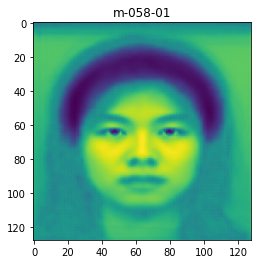

3/3 [==============================] - 0s 3ms/step


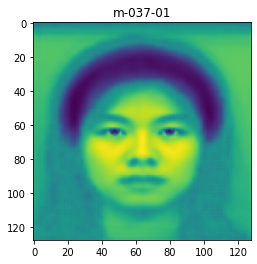

3/3 [==============================] - 0s 3ms/step


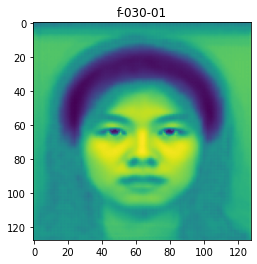

3/3 [==============================] - 0s 3ms/step


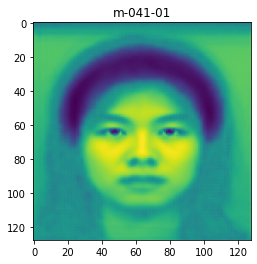

3/3 [==============================] - 0s 3ms/step


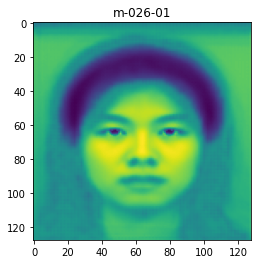

3/3 [==============================] - 0s 3ms/step


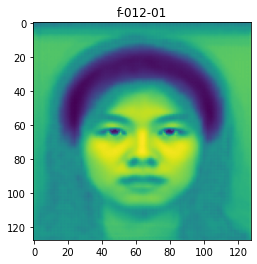

3/3 [==============================] - 0s 3ms/step


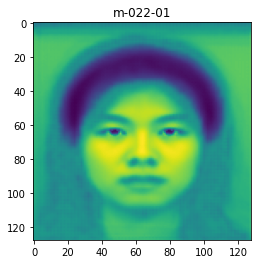

3/3 [==============================] - 0s 3ms/step


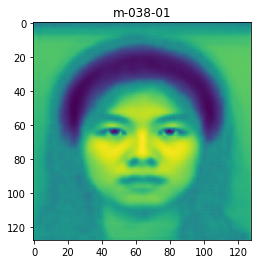

3/3 [==============================] - 0s 3ms/step


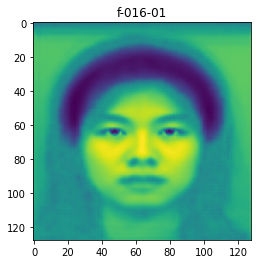

3/3 [==============================] - 0s 3ms/step


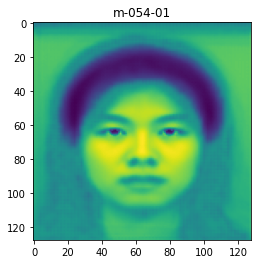

3/3 [==============================] - 0s 3ms/step


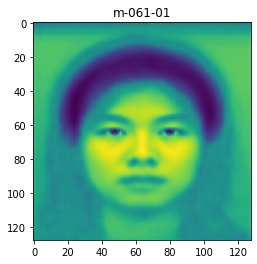

3/3 [==============================] - 0s 3ms/step


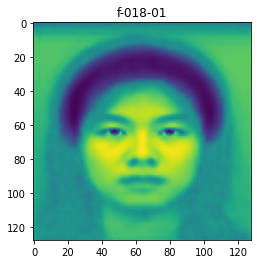

3/3 [==============================] - 0s 3ms/step


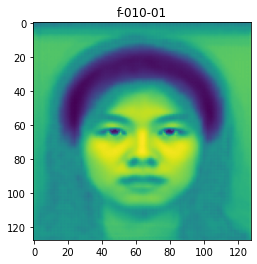

3/3 [==============================] - 0s 3ms/step


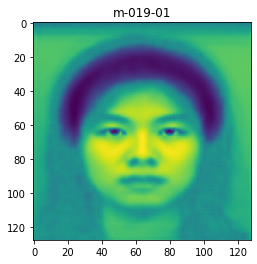

3/3 [==============================] - 0s 3ms/step


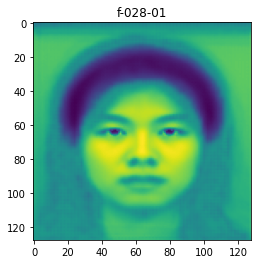

3/3 [==============================] - 0s 3ms/step


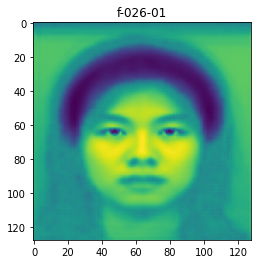

3/3 [==============================] - 0s 3ms/step


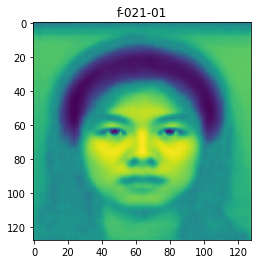

3/3 [==============================] - 0s 3ms/step


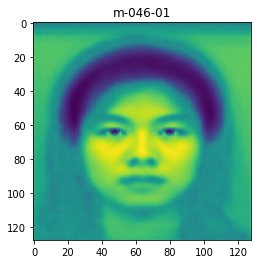

3/3 [==============================] - 0s 3ms/step


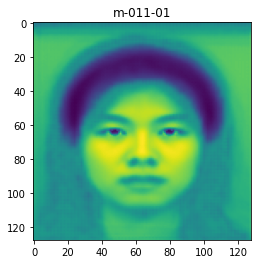

3/3 [==============================] - 0s 3ms/step


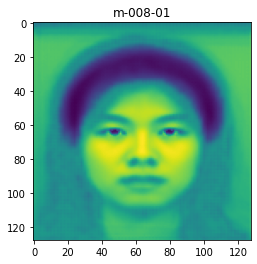

3/3 [==============================] - 0s 3ms/step


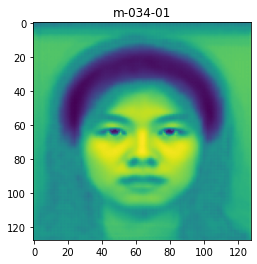

3/3 [==============================] - 0s 3ms/step


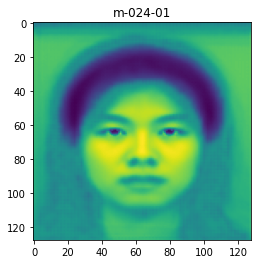

3/3 [==============================] - 0s 3ms/step


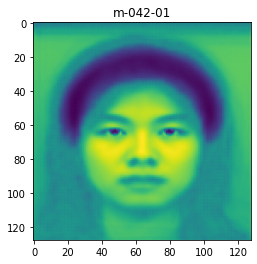

3/3 [==============================] - 0s 3ms/step


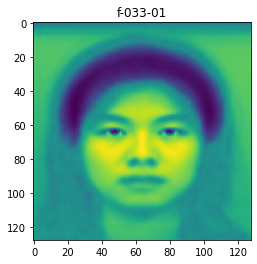

3/3 [==============================] - 0s 3ms/step


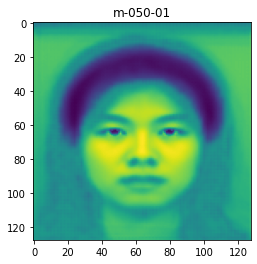

3/3 [==============================] - 0s 3ms/step


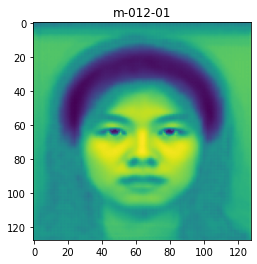

3/3 [==============================] - 0s 3ms/step


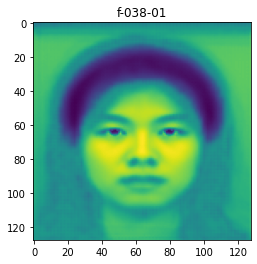

3/3 [==============================] - 0s 3ms/step


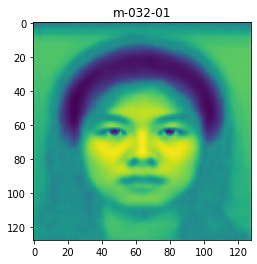

3/3 [==============================] - 0s 3ms/step


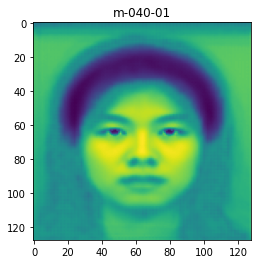

3/3 [==============================] - 0s 3ms/step


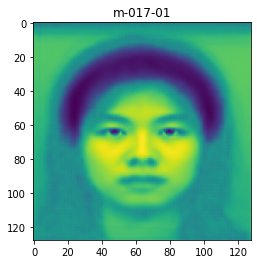

3/3 [==============================] - 0s 3ms/step


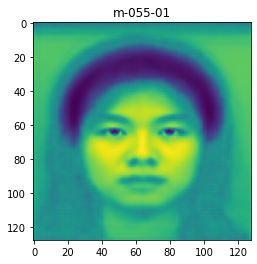

3/3 [==============================] - 0s 3ms/step


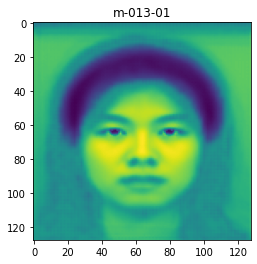

3/3 [==============================] - 0s 3ms/step


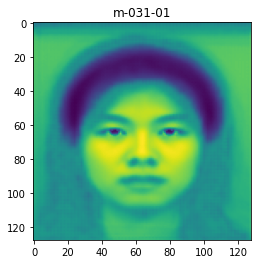

3/3 [==============================] - 0s 3ms/step


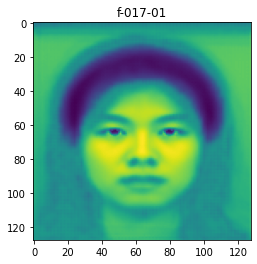

3/3 [==============================] - 0s 3ms/step


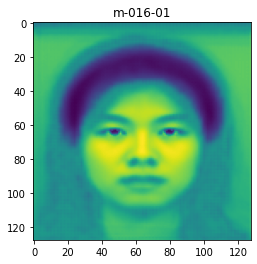

3/3 [==============================] - 0s 3ms/step


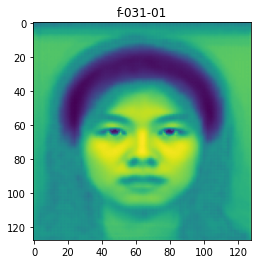

3/3 [==============================] - 0s 3ms/step


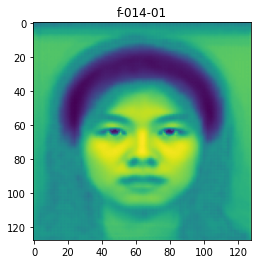

3/3 [==============================] - 0s 3ms/step


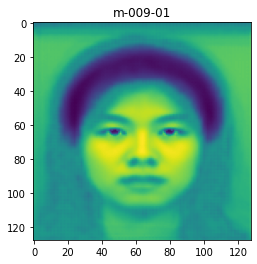

3/3 [==============================] - 0s 3ms/step


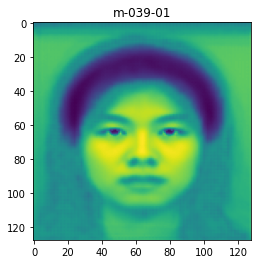

3/3 [==============================] - 0s 3ms/step


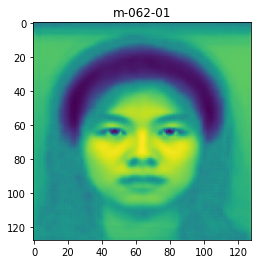

3/3 [==============================] - 0s 3ms/step


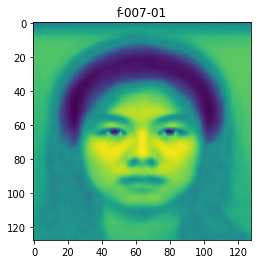

3/3 [==============================] - 0s 3ms/step


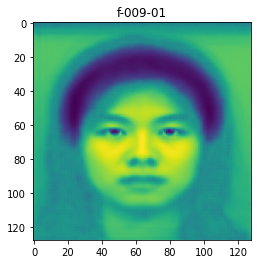

3/3 [==============================] - 0s 3ms/step


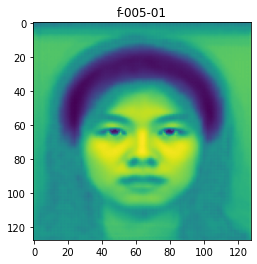

3/3 [==============================] - 0s 3ms/step


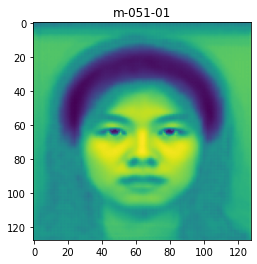

3/3 [==============================] - 0s 4ms/step


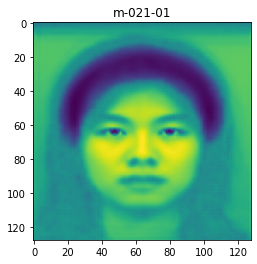

3/3 [==============================] - 0s 3ms/step


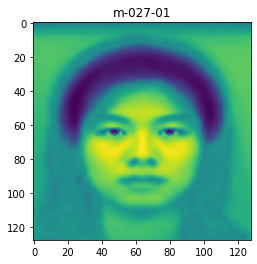

3/3 [==============================] - 0s 3ms/step


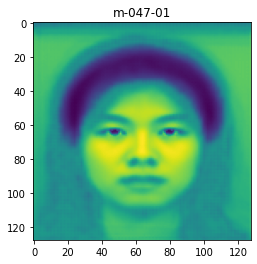

3/3 [==============================] - 0s 3ms/step


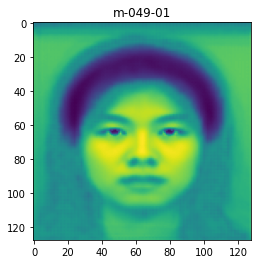

3/3 [==============================] - 0s 3ms/step


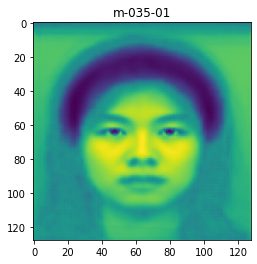

3/3 [==============================] - 0s 3ms/step


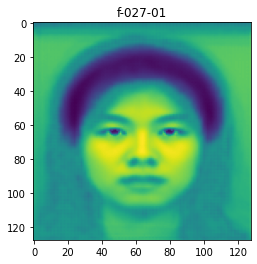

3/3 [==============================] - 0s 3ms/step


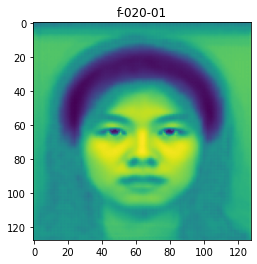

3/3 [==============================] - 0s 3ms/step


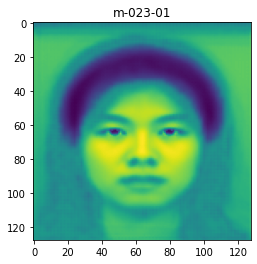

3/3 [==============================] - 0s 3ms/step


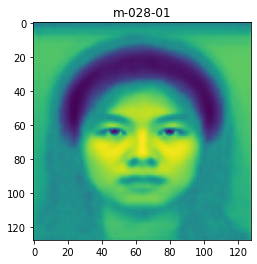

3/3 [==============================] - 0s 3ms/step


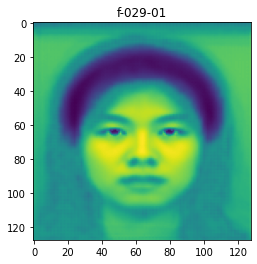

3/3 [==============================] - 0s 3ms/step


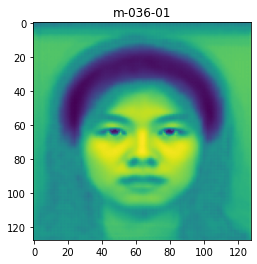

IsADirectoryError: ignored

In [27]:
# 使用VAE模型生成素描图片
for fileName in os.listdir(filePath):
    # 读取输入图片
    img_tmp = Image.open(os.path.join(filePath, fileName)).convert('L')
    
    # 转换为模型的输入格式
    img_tmp = img_tmp.resize((128, 128))
    img_tmp = np.array(img_tmp).reshape((1,128,128,1)).astype('float32') / 255.

    # 使用VAE模型生成素描图片
    z_mean, _, _ = encoder.predict(x_train, batch_size=batch_size)
    sketch_img = decoder.predict(z_mean)

    # 转换为PIL Image格式并保存为文件
    sketch_img = sketch_img[0] * 255.
    #sketch_img = np.clip(sketch_img, 0, 255).astype('uint8')
    sketch_img = sketch_img.astype('uint8').reshape((*sketch_img.shape[:-1],))
    sketch_img = Image.fromarray(sketch_img)
    #sketch_filename = os.path.splitext(fileName)[0] + "_predSketch.jpg"
    #sketch_img.save(os.path.join(filePath, sketch_filename))

    # 显示生成的素描图片
    plt.imshow(sketch_img)
    plt.title(os.path.splitext(fileName)[0])
    plt.show()